In [ ]:
!pip install lightgbm --install-option=--gpu

In [3]:
import shap# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# activity key, value pair
do_hyperparameter_tuning = False
activitis_dict = {"Indoor climbing" : 1, "Run" : 2, "Strength training" : 3, "Swim" : 4, "Bike" : 5, "Dancing" : 6, 
             "Stairclimber" : 7, "Spinning" : 8, "Walking" : 9, "HIIT" : 10, "Outdoor Bike" : 11, "Walk" : 12, "Aerobic Workout" : 13,
             "Tennis" : 14, "Workout" : 15, "Hike" : 16, "Zumba": 17, "Sport" : 18, "Yoga" : 19, "Swimming" : 20, "Weights" : 21,
             "Running" : 22, "Cycling" : 23, "CoreTraining" : 24, "-1" : -1}

# Data Preprocessing

In [5]:
class Explore_Dataset_and_Post_Processing:
    def __init__(self, train_csv_path):
        assert train_csv_path is not None, "train_csv_path cannot be none"
        self.train_csv_path = train_csv_path
        self.train_df = pd.read_csv(self.train_csv_path)
        self.column_prefixes = ['bg', 'insulin', 'carbs', 'hr', 'steps', 'cals', 'activity']
    
    # some general functions
    def get_shape(self):
        return self.train_df.shape
    
    def get_df_description(self):
        return self.train_df.describe()
    
    def get_column_wise_null(self):
        """
        return the number of values that are null
        """
        return self.train_df.isnull().sum()
    
    def get_percentage_of_missing_values(self): 
        """
        returns the pecentage of missing values
        """
        # getting the percentage of missing values
        missing_values = self.train_df.isnull().sum()
        total_rows = self.train_df.shape[0]
        missing_percentage = (missing_values / total_rows) * 100

        results_df = pd.DataFrame({'Column': missing_values.index,
                                  'Missing Values': missing_values.values,
                                  'Missing Percentage (%)': missing_percentage.values})

        results_df = results_df.sort_values(by='Missing Percentage (%)', ascending=False)
        return results_df
    
    def pp_convert_datetime(self):
        """
        converts the time column to date and time
        """
        assert ptypes.is_datetime64_any_dtype(self.train_df["time"]) is not True, "DateTime is already converted" 
        self.train_df.time = pd.to_datetime(self.train_df.time, format='%H:%M:%S')
        return self
        
    def pp_replace_null_values(self):
        """
        replace all null values with 0
        """
        # check if nan values are present
        has_nan = self.train_df.isnull().values.any()
        if not has_nan:
            print("No existing null values in the dataframe.")
        else:
            self.train_df = self.train_df.fillna(0)
        return self
    
    def pp_replace_null_with_fill_forward(self):
        """
        Replacing the Nan with values with fill forward for bg, insulin and heartrate columns
        Reference : https://www.kaggle.com/code/vineetgupta2023/key-insights-from-xgboost-score-2-200
        """
        # blood glucose
        bg_columns = [col for col in self.train_df.columns if col.startswith('bg-')]
        self.train_df[bg_columns] = self.train_df[bg_columns].fillna(method='ffill', axis=1)
        self.train_df[bg_columns] = self.train_df[bg_columns].fillna(method='bfill', axis=1)
        
        # insulin
        insulin_columns = [col for col in self.train_df.columns if col.startswith('insulin-')]
        self.train_df[insulin_columns] = self.train_df[insulin_columns].fillna(method='ffill', axis=1)
        self.train_df[insulin_columns] = self.train_df[insulin_columns].fillna(method='bfill', axis=1)
        
        # heart rate
        hr_columns = [col for col in self.train_df if col.startswith('hr-')]
        self.train_df[hr_columns] = self.train_df[hr_columns].fillna(method='ffill', axis=1)
        self.train_df[hr_columns] = self.train_df[hr_columns].fillna(method='bfill', axis=1)
        return self

    def pp_fill_Nan_with_negative_one(self):
        """
        function to fill the 
        """
        self.train_df = self.train_df.fillna(-1)
        return self
    
    def pp_drop_id_pnum_column(self):
        self.train_df = self.train_df.drop(["id", "p_num", "time"], axis=1)
        return self
        
    def pp_map_activities_to_number(self, activity_dict):
        """
        Fuction to map the activity names to integers
        """
        # get all the columns with name activity
        try:
            activity_columns = list(self.train_df.filter(like='activity').columns)
            #self.train_df[activity_columns] = self.train_df[activity_columns].replace(activitis_dict)
            for col in activity_columns:
                self.train_df[col] = self.train_df[col].apply(lambda x: activitis_dict.get(x, -1) if x != '' else -1)
        except AssertionError as e:
            print(f"AssertionError caught: {e}")
        return self
            
    def pp_replace_nan_with_mean(self):
        """
        Function to replace the nan values with mean
        """
        # get the numerical columns in the dataset
        numerical_columns = self.train_df.select_dtypes(include = ['number']).columns
        
        # now replace for every column with nan values the  mean of that column
        self.train_df[numerical_columns] = self.train_df[numerical_columns].apply(lambda col: col.fillna(col.mean()))
        return self
        
    def pp_normalize_numerical_values(self):
        """
        Normlaize the numerical values. Here we do min ma normalization
        """
        # get the numerical columns in the dataset
        numerical_columns = list(self.train_df.select_dtypes(include = ['number']).columns)
        for column in numerical_columns:
            self.train_df[column] = (self.train_df[column] - self.train_df[column].min()) / (self.train_df[column].max() - self.train_df[column].min())
            
        return self
        
    def pp_impute_numeical_columns(self):
        numerical_columns = list(self.train_df.select_dtypes(include = ['number']).columns)
        try:
            numerical_columns.remove('bg+1:00')
        except:
            pass
        imputer = SimpleImputer(strategy='mean')
        self.train_df[numerical_columns] = imputer.fit_transform(self.train_df[numerical_columns])
        scaler = StandardScaler()
        self.train_df[numerical_columns] = scaler.fit_transform(self.train_df[numerical_columns])
        return self
        
    def pp_encode_categorical_columns(self):
        categorical_cols = [col for col in self.train_df.columns if 'activity' in col]
        for col in categorical_cols:
            self.train_df[col] = self.train_df[col].fillna('None')
            le = LabelEncoder()
            self.train_df[col] = le.fit_transform(self.train_df[col])
        return self

    def pp_drop_columns_with_missing_values(self, missing_df,pecentage):
        """
        missing_value_df : o/p of the function obtained from "get_percentage_of_missing_values"
        percentage : column with missing values >= pecentage is dropped for training and testing
        """
        # list of columns with missing values  > 90
        filtered_columns = missing_df[missing_df['Missing Percentage (%)'] > pecentage]['Column'].tolist()
        # now drop all these columns
        self.train_df = self.train_df.drop(filtered_columns, axis = 1)
        return self

    def pp_carbs_by_doing_hourly_average(self):
        """
        In this we do the average of the carbs columns.
        -We average the value of carbs every hour
        -Hence instead of 12 columns per hour (5 mins interval column), we get 1 column
        -As we know there is an enormous amount of NaN values in the carbs column, this will atleast help in
        reducing the number of NaN values
        """
        # get all the carbs columns 
        carbs_columns = [col for col in self.train_df.columns if col.startswith('carbs-')]
        hours = ['5', '4', '3', '2', '1', '0']
        for h in hours:
             carb_hour_columns = [name for name in carbs_columns if name.startswith("carbs-" + h)]
             self.train_df["average-"+h+"-carbs"] = self.train_df[carb_hour_columns].mean(axis=1)
        return self

    def pp_steps_by_doing_hourly_average(self):
        """
        Here we tahe the average of the steps column
        from my EDA, I have seen second biggest missing value column is steps
        Hence averaging steps can be also used to reduce dimensionality
        """
        # get all the steps columns
        steps_columns = [col for col in self.train_df.columns if col.startswith('steps-')] 
        hours = ['5', '4', '3', '2', '1', '0']
        for h in hours:
             step_hour_column = [name for name in steps_columns if name.startswith("steps-" + h)]
             self.train_df["average-"+h+"-steps"] = self.train_df[step_hour_column].mean(axis=1)
        return self

    def pp_drop_a_list_of_columns_if_needed(self, prefix):
        """
        This function will help in dropping a list of columns  
        which we might not be interested in pitting into our training data.
        It will drop all the columns with that specific prefix
        """
        assert prefix in self.column_prefixes, "Please provide the right prefix. The right prefixes are {}".format(self.column_prefixes)
        columns_to_drop = [col for col in self.train_df.columns if col.startswith(prefix + '-')]
        self.train_df = self.train_df.drop(columns_to_drop, axis = 1)
        return self

    def pp_column_renaming(self):
        
        """
        In LightGBM the column names cannot have special characters and hence this is needed
        """
        self.train_df.columns = self.train_df.columns.str.replace(r'[^\w\s]', '', regex=True)
        return self

    def pp_select_columns_as_features(self, column_list):
        self.train_df = self.train_df[column_list]
        return self
        
    def get_final_df(self):
        return self.train_df

# Dataset Creation

In [6]:
class DatasetCreation:
    def __init__(self, train_df, activities_dict, train_ratio, test_ratio):
        self.actvities_dict = activities_dict
        """
        few assertions and checks needed to be done
        """
        # check if all nun values are non eistent
        if train_df.isnull().values.any():
            raise ValueError("There should not be NaN in training data")
        
        # assert that id and p_num is dropped
        columns = list(train_df.columns)
        assert "id" not in columns, "There should not be the id column"
        assert "p_num" not in columns, "There should not be the p_num column"
        
        # check that all the activities column have dtype float64
        activity_columns = list(train_df.filter(like='activity').columns)
        for col in activity_columns:
            for value in train_df[col]:
                if value == 0:
                    pass
                elif value not in self.actvities_dict.values():
                    raise AssertionError(f"Value {value} in column {col} was not correctly mapped!")
        
        # check if train and test ratio is float
        assert isinstance(train_ratio, float), f"Expected float, but got {type(x).__name__}"
        assert isinstance(test_ratio, float), f"Expected float, but got {type(x).__name__}"
        
        self.train_df = train_df
        self.train_ratio = train_ratio
        self.test_ratio = test_ratio
        
    def return_dataset(self):
        train_X = self.train_df.drop(['bg+1:00'], axis = 1)
        train_Y = self.train_df['bg+1:00']
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(train_X, train_Y, test_size=self.test_ratio, random_state=42)
        
        return X_train_split, X_val_split, y_train_split, y_val_split

In [7]:
train_csv_path = "/kaggle/input/brist1d/train.csv"
obj_data_pipeline = Explore_Dataset_and_Post_Processing(train_csv_path)

# Simple training Data creation pipeline
"""
Here the order of preprocessing is very important
"""
# get the percentage of missing values df
missing_values_df = obj_data_pipeline.get_percentage_of_missing_values()
print(missing_values_df.head())
# preporcessing data
processed_train_df = (obj_data_pipeline
                     .pp_drop_id_pnum_column()
                      # take the avergae of the carbs 
                     #.pp_carbs_by_doing_hourly_average()
                     # drop the other carb columns 
                     .pp_drop_a_list_of_columns_if_needed(prefix='activity')
                     #.pp_replace_null_with_fill_forward()
                     .pp_replace_null_values()
                     #.pp_map_activities_to_number(activitis_dict)
                     #.pp_fill_Nan_with_negative_one()
                     .pp_select_columns_as_features(['bg-0:00', 'bg-0:05', 'bg-0:15','bg+1:00'])
                     .get_final_df())

print("[!] Number of columns in processed df : ", len(processed_train_df.columns))
obj_data_create = DatasetCreation(processed_train_df, activities_dict=activitis_dict, train_ratio=0.8, test_ratio=0.2)
x_train, x_val, y_train, y_val  = obj_data_create.return_dataset()

x_train.columns = x_train.columns.str.replace(r'[^\w\s]', '', regex=True)
x_val.columns = x_val.columns.str.replace(r'[^\w\s]', '', regex=True)

print("Type of X_train : ", type(x_train))

Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.


         Column  Missing Values  Missing Percentage (%)
164  carbs-4:30          174496               98.571945
170  carbs-4:00          174492               98.569685
161  carbs-4:45          174491               98.569121
155  carbs-5:15          174490               98.568556
152  carbs-5:30          174490               98.568556
[!] Number of columns in processed df :  433
Type of X_train :  <class 'pandas.core.frame.DataFrame'>


In [8]:
x_train.head()

,bg555,bg550,bg545,bg540,bg535,bg530,bg525,bg520,bg515,bg510,...,cals045,cals040,cals035,cals030,cals025,cals020,cals015,cals010,cals005,cals000
175765,6.8,6.8,6.8,6.8,6.8,6.8,6.9,6.8,6.7,6.5,...,6.75,6.75,6.75,6.75,6.75,6.75,6.75,6.75,6.75,6.75
164992,8.5,8.3,8.2,8.1,8.0,8.1,8.0,7.8,7.9,7.9,...,6.75,6.75,6.75,6.75,6.75,6.75,6.75,6.75,8.38,6.75
34462,10.8,10.7,10.6,10.6,10.8,10.9,11.0,11.1,11.4,11.5,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
172586,8.9,9.4,10.0,10.7,10.8,11.1,11.0,10.8,10.9,10.7,...,24.89,16.91,11.77,6.75,8.38,22.99,15.97,28.94,6.89,13.26
176352,5.7,5.4,5.3,5.2,5.2,5.1,5.2,5.4,5.7,5.8,...,8.10,8.25,16.24,8.38,8.25,7.44,11.37,15.02,13.26,8.79


# Creating the LightGBM Model

### Using optuna to do hyper parameter tuning
Some technical Notes
1. This process of training over multiple random samples without replacement is called “bagging”. 


def objective_lightgbm(trial):
    start_time = time.time()
    # Define the hyperparameter search space
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "device_type" : "gpu",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0), #over-fitting parameter
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0), #over-fitting parameter
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),#controlling complexity of tree model
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),# decreasing the number of features to be considered
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),# again draw samples of that much % of training data
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),#how many iterations without resampling
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),# minimum number of data in a leaf
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
    }

    # Create LightGBM dataset
    train_data = lgb.Dataset(x_train, label=y_train)
    valid_data = lgb.Dataset(x_val, label=y_val, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        num_boost_round=1000,
        #early_stopping_rounds=20,
        #verbose_eval=False,
    )

    # Predict and calculate RMSE
    preds = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, preds, squared=False))

    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Print elapsed time for the trial
    print(f"Trial {trial.number} finished in {elapsed_time:.2f} seconds.")
    return rmse


# Create a study and optimize
if do_hyperparameter_tuning:
    import time
    import optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_lightgbm, n_trials=10)
else:
    pass

In [ ]:

import lightgbm
print(lightgbm.__version__)

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_val, label=y_val, reference=train_data)

params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "device_type" : "gpu",
        "lambda_l1": 0.026758431635345595, #over-fitting parameter
        "lambda_l2": 1.1912416629585453e-08, #over-fitting parameter
        "num_leaves": 144,#controlling complexity of tree model
        "feature_fraction": 0.9818350824277666,# decreasing the number of features to be considered
        "bagging_fraction": 0.7450061528836429,# again draw samples of that much % of training data
        "bagging_freq": 2,#how many iterations without resampling
        "min_child_samples": 30,# minimum number of data in a leaf
        "learning_rate": 0.07174143281315025,
    }
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=50)

### Having a check on which of the features contributes to the most

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(x_val)
shap.summary_plot(shap_values, x_val) 

y_pred = model.predict(x_val, num_iteration=model.best_iteration)

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# Save the model
#model.save_model('/kaggle/working/lgb_classifier.txt', num_iteration=model.best_iteration) 

# Creating a CATBOOST MODEL

In [9]:
from catboost import CatBoostRegressor, Pool

In [13]:
model = CatBoostRegressor(
    iterations=1000,    # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=6,            # Depth of each tree
    verbose=100         # Verbosity to monitor training
)
model.fit(x_train, y_train, eval_set=(x_val, y_val), use_best_model=True)

0:	learn: 2.8591814	test: 2.8746706	best: 2.8746706 (0)	total: 202ms	remaining: 3m 22s
100:	learn: 1.9732480	test: 2.0164604	best: 2.0164604 (100)	total: 12.5s	remaining: 1m 51s
200:	learn: 1.9001401	test: 1.9621489	best: 1.9621489 (200)	total: 24.5s	remaining: 1m 37s
300:	learn: 1.8514663	test: 1.9312757	best: 1.9312757 (300)	total: 36s	remaining: 1m 23s
400:	learn: 1.8124574	test: 1.9092654	best: 1.9092654 (400)	total: 47.3s	remaining: 1m 10s
500:	learn: 1.7781666	test: 1.8911492	best: 1.8911492 (500)	total: 59.1s	remaining: 58.8s
600:	learn: 1.7478543	test: 1.8764384	best: 1.8764384 (600)	total: 1m 10s	remaining: 46.7s
700:	learn: 1.7198205	test: 1.8624942	best: 1.8624942 (700)	total: 1m 21s	remaining: 34.9s
800:	learn: 1.6926050	test: 1.8493115	best: 1.8493115 (800)	total: 1m 33s	remaining: 23.3s
900:	learn: 1.6687035	test: 1.8381111	best: 1.8381111 (900)	total: 1m 44s	remaining: 11.5s
999:	learn: 1.6444171	test: 1.8268711	best: 1.8268711 (999)	total: 1m 56s	remaining: 0us

bestTes

In [15]:
y_pred = model.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [16]:
rmse

1.8268710776875705

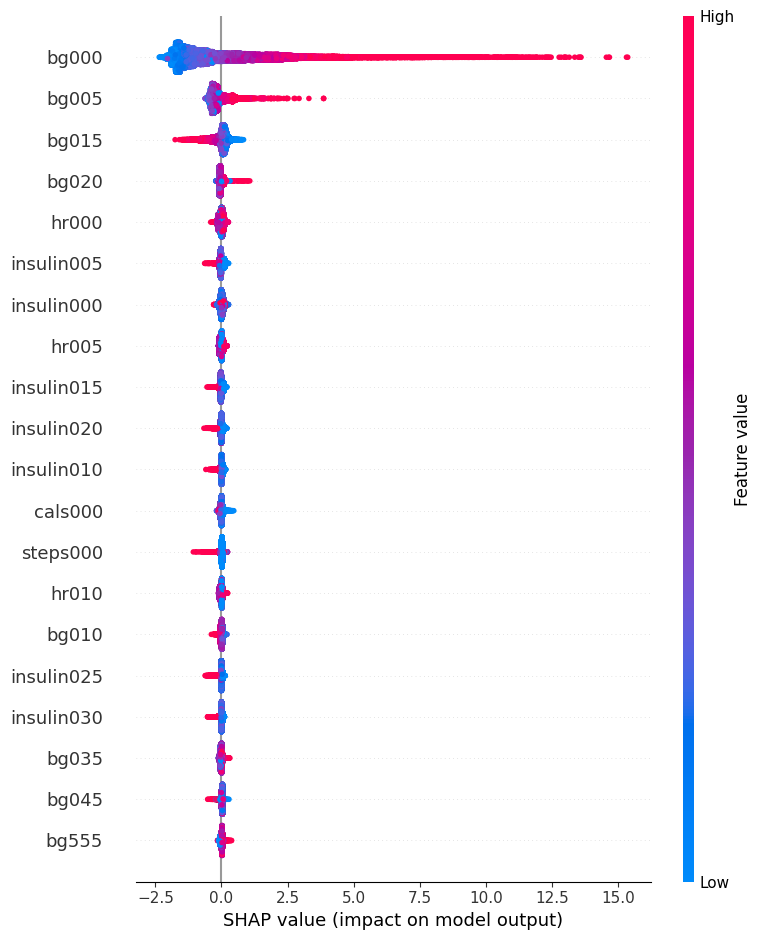

In [20]:
explainer = shap.Explainer(model)
shap_values = explainer(x_val)
shap.summary_plot(shap_values, x_val) 

# Creating the Submission

In [18]:
#test_csv = pd.read_csv("/kaggle/input/brist1d/test.csv")
test_csv_path = "/kaggle/input/brist1d/test.csv"
obj_data_pipeline = Explore_Dataset_and_Post_Processing(test_csv_path)

# Simple training Data creation pipeline
"""
Here the order of preprocessing is very important
"""
# get the percentage of missing values df
missing_values_df = obj_data_pipeline.get_percentage_of_missing_values()
print(missing_values_df.head())
# preporcessing data
processed_test_df = (obj_data_pipeline
                     .pp_drop_id_pnum_column()
                      # take the avergae of the carbs 
                     #.pp_carbs_by_doing_hourly_average()
                     # drop the other carb columns 
                     .pp_drop_a_list_of_columns_if_needed(prefix='activity')
                     #.pp_replace_null_with_fill_forward()
                     .pp_replace_null_values()
                     #.pp_map_activities_to_number(activitis_dict)
                     #.pp_fill_Nan_with_negative_one()
                     #.pp_select_columns_as_features(['bg-0:00', 'bg-0:05', 'bg-0:15','bg+1:00'])
                     .get_final_df())
processed_test_df.columns = processed_test_df.columns.str.replace(r'[^\w\s]', '', regex=True)
predictions = model.predict(processed_test_df)
print(predictions)

            Column  Missing Values  Missing Percentage (%)
445  activity-5:05            3614               99.176729
444  activity-5:10            3614               99.176729
442  activity-5:20            3612               99.121844
443  activity-5:15            3611               99.094402
446  activity-5:00            3611               99.094402
[7.68075096 5.7132718  8.33176112 ... 6.4799818  8.42763094 6.86791764]


In [19]:
# load submission 
submission_df = pd.read_csv("/kaggle/input/brist1d/sample_submission.csv")
submission_df['bg+1:00'] = predictions
# Save the submission file
submission_df.to_csv('submission.csv', index=False)